In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ray tracing
from OceanRays.SoundSpeed import CTDSoundSpeed
from OceanRays.RayPaths import RayTrace, plotProfileRaypaths
# build tables
from OceanRays.TravelTimes import interpXZT,buildTTLookupTable
# read existing tt-table
import pickle
# read CTD data
from seabird.cnv import fCNV

import time
# run simple ray-path calculations through a theoretical (Munk) sound speed profile
# be careful of low angles when in the sofar channel for obvious reasons (waveguides)
initial_depth = 6000  # meters
max_range = 50e3    # meters (lateral distance)
angles = [-80, -65, -50, -35] # degrees
 
# From CTD Data
infile='../CTD_examples/SKQ202409S_009avg.cnv'
profile = fCNV(infile) 

CMac = CTDSoundSpeed(profile, model='Mackenzie')


/Users/an77/anaconda3/envs/oceanrays/lib/python3.13/site-packages/seabird/cnv.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# now loop over array of angles and depths
min_depth=5000 # meters   (only need to build table for your specific depth and distance ranges.  Doing more now for vis)
max_depth=6000 # meters
dz=40 # meters (smaller steps are more accurate but more computationally expensive)

min_angle = -90 # degrees
max_angle = -40 # degrees
da = 0.25 # degrees (see dz)
max_range_m = 50000  # meters (max distance to calc ray path)

dt = 0.02  # seconds (see dz)

# Munk example
#lookupxzt = buildTTLookupTable([min_angle,max_angle,da],[min_depth,max_depth,dz],maxRange=max_range_m, dt=dt)

# using real data (much slower)
lookupxzt = buildTTLookupTable([min_angle,max_angle,da],[min_depth,max_depth,dz],maxRange=max_range_m, zProfile=profile['DEPTH'],cProfile=CMac, dt=dt)
print(f"Lookup table size: {len(lookupxzt)} entries.");
print("By default, lookup table will be saved as TTtable.pkl.  This doesn't need to be reran for same area")

#mv TTtable.pkl CTD_examples/SKQ_009_TTtable_0-6kz20mdz_90-40deg0.1daz_0.02dt.pkl

Building lookup table for travel time by (range, initial_depth)... (parallelized)
Progress: 100/5226
Progress: 200/5226
Progress: 300/5226
Progress: 400/5226
Progress: 500/5226
Progress: 600/5226
Progress: 700/5226
Progress: 800/5226
Progress: 900/5226
Progress: 1000/5226
Progress: 1100/5226
Progress: 1200/5226
Progress: 1300/5226
Progress: 1400/5226
Progress: 1500/5226
Progress: 1600/5226
Progress: 1700/5226
Progress: 1800/5226
Progress: 1900/5226
Progress: 2000/5226
Progress: 2100/5226
Progress: 2200/5226
Progress: 2300/5226
Progress: 2400/5226
Progress: 2500/5226
Progress: 2600/5226
Progress: 2700/5226
Progress: 2800/5226
Progress: 2900/5226
Progress: 3000/5226
Progress: 3100/5226
Progress: 3200/5226
Progress: 3300/5226
Progress: 3400/5226
Progress: 3500/5226
Progress: 3600/5226
Progress: 3700/5226
Progress: 3800/5226
Progress: 3900/5226
Progress: 4000/5226
Progress: 4100/5226
Progress: 4200/5226
Progress: 4300/5226
Progress: 4400/5226
Progress: 4500/5226
Progress: 4600/5226
Progres

In [3]:
# Example usage:
# Once a table is created and loaded, determining the travel time to a specific point or distances is very fast
# If you make a very detailed model, the interpolation will take longer, but I don't see a noticable (few %) change
# when increasing the vector inputs by an order of magnitude.  Thus,  it'd be better to make
# a single vectorized call for all distances than to call over and over again.

x = np.linspace(1000, 5500, 10001)
z = np.linspace(5000, 5000, 10001) 

start = time.time()
tcubic = interpXZT(x, z, lookupxzt, method='cubic')
end = time.time()

print("Predicted Travel Times:", tcubic)
print("Calculations for ", len(tcubic), "times:", end - start)

Predicted Travel Times: [3.39968374 3.39974325 3.39980279 ... 4.95498222 4.9552041  4.95542599]
Calculations for  10001 times: 0.5088870525360107


In [4]:
# Load a saved version that has much higher sampling (only between 4500 and 6000 m depth)
lookupxzt2 = pickle.load(open("../CTD_examples/SKQ_009_TTtable.pkl", "rb"))

In [5]:

print("Predicted Travel Times:", tcubic)
start = time.time()
tcubic = interpXZT(x, z, lookupxzt2, method='cubic')
end = time.time()

print("Predicted Travel Times:", tcubic)
print("Calculations for ", len(tcubic), "times:", end - start)


Predicted Travel Times: [3.39968374 3.39974325 3.39980279 ... 4.95498222 4.9552041  4.95542599]
Predicted Travel Times: [3.40513472 3.40519317 3.40525169 ... 4.96298326 4.96320586 4.96342856]
Calculations for  10001 times: 0.7369787693023682


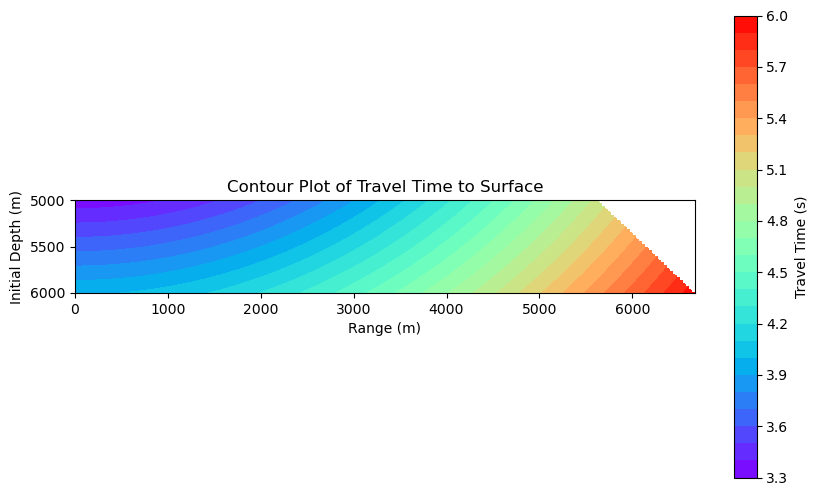

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for contour plot from lookupxzt
lookup_XZ = np.array(list(lookupxzt.keys()))  # shape (N, 2): columns are (range, depth)
lookup_times = np.array(list(lookupxzt.values()))  # shape (N,)

# Create grid for contour plot
range_grid = np.linspace(lookup_XZ[:,0].min(), lookup_XZ[:,0].max(), 200)
depth_grid = np.linspace(lookup_XZ[:,1].min(), lookup_XZ[:,1].max(), 200)
R, D = np.meshgrid(range_grid, depth_grid)
points = np.column_stack([R.ravel(), D.ravel()])

from scipy.interpolate import griddata
T = griddata(lookup_XZ, lookup_times, points, method='linear')
T = T.reshape(R.shape)

plt.figure(figsize=(10,6))
contour = plt.contourf(R, D, T, levels=30, cmap='rainbow')
plt.colorbar(contour, label='Travel Time (s)')
plt.xlabel('Range (m)')
plt.ylabel('Initial Depth (m)')
plt.title('Contour Plot of Travel Time to Surface')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()